# Position bias etimation with real data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../

/shared/shion/embed_position_bias


In [4]:
from sklearn.linear_model import LogisticRegression
import pickle
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import rel_entr
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.logistic_epsilon_greedy import LogisticEpsilonGreedy
from src.simulator import run_timeseries_simulation
from sklearn.feature_selection import VarianceThreshold
from src.embedding import convert_to_p_e_given_a, resample_dataset_with_embed_vector, get_embedding_with_LSI
sns.set()

# (1) Load dataset and preprocessing

In [5]:
df = pd.read_csv('data/all.csv', index_col=0)
item_features = pd.read_csv('data/item_context.csv', index_col=0)

/usr/local/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
df = pd.merge(df, item_features, how='left', on='item_id')

In [12]:
df

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,2019-11-24 00:00:00.007365+00:00,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.409964,d1e00cff339048c08ea666193d5033a3,f676eed05902d205b7b42fd403171834,ad64ce82bf623357a97a1164f463a5da
1,2019-11-24 00:00:00.015668+00:00,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.521473,d1e00cff339048c08ea666193d5033a3,f676eed05902d205b7b42fd403171834,ad64ce82bf623357a97a1164f463a5da
2,2019-11-24 00:00:00.016438+00:00,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.521473,9eeef99c68d05dee33645a764e61f0ff,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
3,2019-11-24 00:00:01.856987+00:00,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.655285,e3f540fa6d7911cd4ec38f8c3da11e67,b20fef9a0c93b1fe9cc2a7989f84c8ac,57bed6721fd0a0f839271cdf0e9fb2c1
4,2019-11-24 00:00:01.857185+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.660526,bfcc6df8d05cd9f88e9f8cd2e68004e0,f676eed05902d205b7b42fd403171834,ad64ce82bf623357a97a1164f463a5da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374322,2019-11-30 23:59:59.403871+00:00,16,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.660526,d1e00cff339048c08ea666193d5033a3,7d8a605a5ed97e19765e7135d6a69eac,c3076613abe7b4363a68a27890d8ba57
1374323,2019-11-30 23:59:59.403885+00:00,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.521473,d1e00cff339048c08ea666193d5033a3,f676eed05902d205b7b42fd403171834,ad64ce82bf623357a97a1164f463a5da
1374324,2019-11-30 23:59:59.407555+00:00,17,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,05b76f5e97e51128862059ac7df9e42a,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.441091,d1e00cff339048c08ea666193d5033a3,55e5ab40f7a3dbb17d523a8af0abb80a,ff8b1f6688f83613aecd3fbc881bafb0
1374325,2019-11-30 23:59:59.408786+00:00,48,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,05b76f5e97e51128862059ac7df9e42a,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.432266,e3f540fa6d7911cd4ec38f8c3da11e67,05a71ea0e32925d42ae7284196de3f2e,029e121cef34dc8045ea5eed5cc181a9


In [13]:
# parameter of experiment (in the dataset of open bandit dataset, there is )
trials = 5
num_embeddings = 15
num_slot = 10
np.random.seed(0)

In [14]:
df = df.rename(columns = {'item_id':'arm', 'position':'slot'})

In [15]:
def pretrained_position_bias(num_position):
    # pre-estimated position biases by previous study in ebay
    # Reference : https://deepai.org/publication/direct-estimation-of-position-bias-for-unbiased-learning-to-rank-without-intervention
    position_biases = {}
    for i in range(2, num_position + 2):
        position_biases[i - 2] = min(1, 1 / np.log(i))
    # add later to avoid dividing by 0
    return position_biases


In [16]:
true_position_bias = pretrained_position_bias(num_slot)

In [17]:
df['slot'] = np.random.randint(num_slot, size=len(df))

In [371]:
# position bias resample for synthetic experiment
# why I used open bandit -> we need several observations to calculate position bias
df['click'] = np.random.rand(len(df)) < df['slot'].map(true_position_bias) * df['click']

In [372]:
# undersample df
negatives = df[df.click==False].sample(len(df[df.click==True])*10)
df = pd.concat([negatives, df[df.click==True]])

# (2) Estimate position_bias of real_dataset

In [271]:
# preperation of simulation
sdf = df
# in carousel, arms are shown at the same time and uniform
pscore = np.ones((len(sdf), len(sdf.slot.unique())))
pscore /= len(sdf.slot.unique())
bandit_feedback = {
    "action": sdf.arm.values,
    "position": sdf.slot.values,
    "reward": sdf.click.values,
    "n_rounds": len(sdf),
    "n_actions": len(sdf.arm.unique()),
    "pscore": pscore,
    "context": sdf.iloc[:, 5:].values
}

action_spec = {
    "arms": list(sdf.arm.unique()),
    "slots":list(sdf.slot.unique()),
}

policy_state_spec = {
    "model": "xgboost",
    "optimize_slot": True,
    "epsilon": 1,
    "epsilon_decay": 0.9,
    "epsilon_min": 0.01,
}

In [272]:
i = 0
pbias_real = pd.DataFrame()
while i < trials:
    print(f'trial {i}')
    # calculate position bias with whole data
    leg = LogisticEpsilonGreedy(action_spec, policy_state_spec=policy_state_spec)
    leg.update(
            bandit_feedback["action"],
            bandit_feedback["reward"],
            context = bandit_feedback["context"],
            position = bandit_feedback["position"],
    )
    pbias = leg.position_bias.sort_index()
    pbias_real = pd.concat([pbias_real, pbias/pbias.max()])
    if pbias.std() < 0.001:
        continue
    pbias_real = pd.concat([pbias_real, pbias/pbias.max()])
    i = i+1

trial 0
epsilon: {} 0.9
trial 1
epsilon: {} 0.9
trial 2
epsilon: {} 0.9


In [273]:
pbias_real.columns = ['position_bias']
pbias_real['position'] = pbias_real.index

<AxesSubplot:xlabel='position', ylabel='position_bias'>

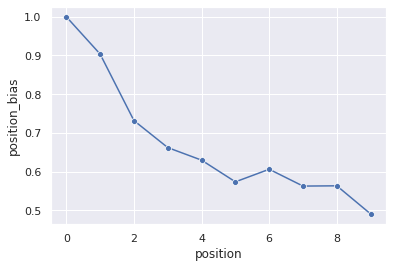

In [274]:
sns.lineplot(data=pbias_real.reset_index(), x='position', y='position_bias', err_style='bars', marker='o')

In [242]:
pbias_real.to_csv('pbias_real_obd.csv')

# (3) Apply embedding for sparse dataset

In [243]:
gooditem_order = list(df.groupby(['arm']).mean()['click'].sort_values(ascending=False).index)



In [258]:
item2fixslot= dict(zip(gooditem_order, np.hstack([np.arange(10)]*8)))

In [259]:
# create sparse dataset
df_subset = df[df.arm.map(item2fixslot) == df.slot]

In [260]:
item_features = pd.read_csv('data/item_context.csv', index_col=0)


In [385]:
item_features = pd.concat([item_features.iloc[:, 1], pd.get_dummies(item_features.iloc[:, 2:])], axis=1)

In [388]:
item_features.to_csv('data/item_features_numeric.csv')

In [262]:
# preperation of simulation
sdf = df_subset
# in carousel, arms are shown at the same time and uniform
pscore = np.ones((len(sdf), len(sdf.slot.unique())))
pscore /= len(sdf.slot.unique())
bandit_feedback = {
    "action": sdf.arm.values,
    "position": sdf.slot.values,
    "reward": sdf.click.values,
    "n_rounds": len(sdf),
    "n_actions": len(sdf.arm.unique()),
    "pscore": pscore,
    "context": sdf.iloc[:, 5:].values
}

action_spec = {
    "arms": list(sdf.arm.unique()),
    "slots":list(sdf.slot.unique()),
}

policy_state_spec = {
    "model": "xgboost",
    "optimize_slot": True,
    "epsilon": 1,
    "epsilon_decay": 0.9,
    "epsilon_min": 0.01,
}

In [263]:
i = 0
pbias_subset = pd.DataFrame()
while i < trials:
    print(f'trial {i}')
    # calculate position bias with whole data
    leg_subset = LogisticEpsilonGreedy(action_spec, policy_state_spec=policy_state_spec)
    leg_subset.update(
            bandit_feedback["action"],
            bandit_feedback["reward"],
            context = bandit_feedback["context"],
            position = bandit_feedback["position"],
    )
    pbias = leg_subset.position_bias.sort_index()
    pbias_subset = pd.concat([pbias_subset, pbias/pbias.max()])
    if pbias.std() < 0.001:
        continue
    pbias_subset = pd.concat([pbias_subset, pbias/pbias.max()])
    i = i+1

trial 0
epsilon: {} 0.9
trial 1
epsilon: {} 0.9
trial 2
epsilon: {} 0.9


In [264]:
pbias_subset.columns = ['position_bias']
pbias_subset['position'] = pbias_subset.index

<AxesSubplot:xlabel='position', ylabel='position_bias'>

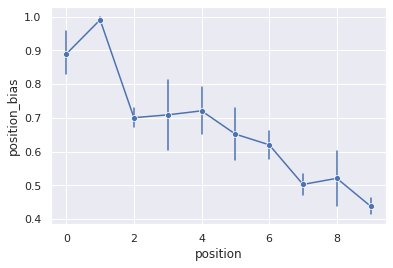

In [265]:

sns.lineplot(data=pbias_subset.reset_index(), x='position', y='position_bias', err_style='bars', marker='o')

In [252]:
pbias_subset.to_csv('pbias_subset_obd.csv')

# (3-1) Apply LSI

In [390]:
i = 0
pbias_lsi = pd.DataFrame()
while i < trials:
    print(f'trial {i}')
    p_e_a = convert_to_p_e_given_a(get_embedding_with_LSI(item_features, num_embeddings))
    df_embed = resample_dataset_with_embed_vector(df_subset, p_e_a, size=3000)
    # preperation of simulation
    # in carousel, arms are shown at the same time and uniform
    pscore = np.ones((len(df_embed), len(df_embed.slot.unique())))
    pscore /= len(df_embed.slot.unique())
    bandit_feedback = {
        "action": df_embed.arm.values,
        "position": df_embed.slot.values,
        "reward": df_embed.click.values,
        "n_rounds": len(df_embed),
        "n_actions": len(df_embed.arm.unique()),
        "pscore": pscore,
        "context": df_embed.iloc[:, 5:].values
    }

    action_spec = {
        "arms": list(df_embed.arm.unique()),
        "slots":list(df_embed.slot.unique()),
    }

    policy_state_spec = {
        "model": "xgboost",
        "optimize_slot": True,
        "epsilon": 1,
        "epsilon_decay": 0.9,
        "epsilon_min": 0.01,
    }
    # calculate position bias with whole data
    leg = LogisticEpsilonGreedy(action_spec, policy_state_spec=policy_state_spec)
    leg.update(
            bandit_feedback["action"],
            bandit_feedback["reward"],
            context = bandit_feedback["context"],
            position = bandit_feedback["position"],
    )
    pbias = leg.position_bias.sort_index()
    # if all values are similar, we skip iteration
    if pbias.std() < 0.01:
        continue
    pbias_lsi = pd.concat([pbias_lsi, pbias/pbias.max()])
    i = i+1

trial 0


3000it [00:01, 1802.08it/s]


epsilon: {} 0.9
trial 1


1131it [00:00, 1694.46it/s]


KeyboardInterrupt: 

In [282]:
pbias_lsi.columns = ['position_bias']
pbias_lsi['position'] = pbias_lsi.index

<AxesSubplot:xlabel='position', ylabel='position_bias'>

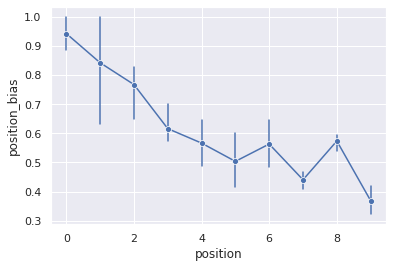

In [283]:

sns.lineplot(data=pbias_lsi.reset_index(), x='position', y='position_bias', err_style='bars', marker='o')

In [284]:
pbias_lsi.to_csv('pbias_lsi_obd.csv')

# (3-2) Apply VAE

In [393]:
i=0
pbias_vae = pd.DataFrame()
while i < trials:
    print(f'trial {i}')
    embedding_vae = pd.read_csv('data/obd_embedding_matrix.csv', index_col=0)
    p_e_a = convert_to_p_e_given_a(embedding_vae.iloc[:, :num_embeddings])
    df_embed = resample_dataset_with_embed_vector(df_subset, p_e_a, size=3000)
    # preperation of simulation
    # in carousel, arms are shown at the same time and uniform
    pscore = np.ones((len(df_embed), len(df_embed.slot.unique())))
    pscore /= len(df_embed.slot.unique())
    bandit_feedback = {
        "action": df_embed.arm.values,
        "position": df_embed.slot.values,
        "reward": df_embed.click.values,
        "n_rounds": len(df_embed),
        "n_actions": len(df_embed.arm.unique()),
        "pscore": pscore,
        "context": df_embed.iloc[:, 5:].values
    }

    action_spec = {
        "arms": list(df_embed.arm.unique()),
        "slots":list(df_embed.slot.unique()),
    }

    policy_state_spec = {
        "model": "xgboost",
        "optimize_slot": True,
        "epsilon": 1,
        "epsilon_decay": 0.9,
        "epsilon_min": 0.01,
    }
    # calculate position bias with whole data
    leg = LogisticEpsilonGreedy(action_spec, policy_state_spec=policy_state_spec)
    leg.update(
            bandit_feedback["action"],
            bandit_feedback["reward"],
            context = bandit_feedback["context"],
            position = bandit_feedback["position"],
    )
    pbias = leg.position_bias.sort_index()
    # if all values are similar, we skip iteration
    if pbias.std() < 0.01:
        continue
    pbias_vae = pd.concat([pbias_vae, pbias/pbias.max()])
    i = i+1

trial 0


3000it [00:01, 1834.40it/s]


epsilon: {} 0.9
trial 1


3000it [00:01, 1745.45it/s]


epsilon: {} 0.9
trial 1


3000it [00:01, 1794.06it/s]


epsilon: {} 0.9
trial 1


3000it [00:01, 1744.90it/s]


epsilon: {} 0.9
trial 2


3000it [00:01, 1908.02it/s]


epsilon: {} 0.9
trial 2


3000it [00:01, 1675.94it/s]


epsilon: {} 0.9
trial 2


3000it [00:01, 1977.30it/s]


epsilon: {} 0.9


<AxesSubplot:xlabel='position', ylabel='position_bias'>

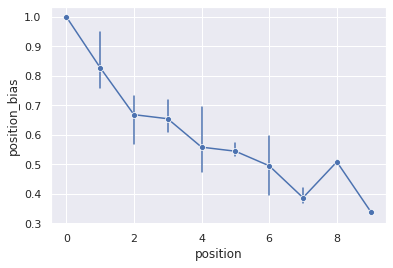

In [394]:
pbias_vae.columns = ['position_bias']
pbias_vae['position'] = pbias_vae.index
sns.lineplot(data=pbias_vae.reset_index(), x='position', y='position_bias', err_style='bars', marker='o')

In [395]:
pbias_vae.to_csv('pbias_vae_obd.csv')

# (4) Evaluation

## (4-1) Calculate MSE 

In [6]:
pbias_lsi = pd.read_csv('pbias_lsi_obd.csv', index_col=0)
pbias_vae = pd.read_csv('pbias_vae_obd.csv', index_col=0)
pbias_real = pd.read_csv('pbias_real_obd.csv', index_col=0)
pbias_subset = pd.read_csv('pbias_subset_obd.csv', index_col=0)

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [9]:
trials = 3

In [10]:
mses = []
for i in range(trials):
    mses.append([
        mean_squared_error(pbias_subset[i:i+df.slot.nunique()]['position_bias'], pbias_real.groupby('position').mean().values),
        mean_squared_error(pbias_lsi[i:i+df.slot.nunique()]['position_bias'], pbias_real.groupby('position').mean().values),
        mean_squared_error(pbias_vae[i:i+df.slot.nunique()]['position_bias'], pbias_real.groupby('position').mean().values)
    ])
mses = pd.DataFrame(mses, columns=['sparse_dataset', 'LSI', 'VAE'])
#mses = pd.DataFrame(mses, columns=['sparse_dataset', 'LSI'])
mses

AttributeError: 'DataFrame' object has no attribute 'slot'

<AxesSubplot:>

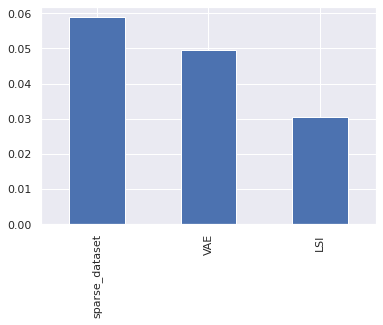

In [407]:
mses.mean().loc[['sparse_dataset','VAE', 'LSI']].plot.bar()

In [291]:
mses.mean()

sparse_dataset    0.058908
LSI               0.030475
dtype: float64

In [292]:
mses.var()

sparse_dataset    0.000082
LSI               0.000452
dtype: float64

In [20]:
mses = []
for i in range(trials):
    mses.append([
        np.sqrt(mean_squared_error(pbias_subset[i:i+df.slot.nunique()]['position_bias'], pd.Series(true_position_bias))),
        np.sqrt(mean_squared_error(pbias_lsi[i:i+df.slot.nunique()]['position_bias'], pd.Series(true_position_bias))),
        np.sqrt(mean_squared_error(pbias_vae[i:i+df.slot.nunique()]['position_bias'], pd.Series(true_position_bias)))
   ])
rmses = pd.DataFrame(mses, columns=['sparse_dataset', 'LSI', 'VAE'])
#mses = pd.DataFrame(mses, columns=['sparse_dataset', 'LSI'])
rmses

,sparse_dataset,LSI,VAE
0,0.256306,0.059404,0.072877
1,0.269128,0.199648,0.222832
2,0.251320,0.235137,0.297384
3,0.257289,0.292096,0.333055
4,0.318801,0.306575,0.357504


<AxesSubplot:>

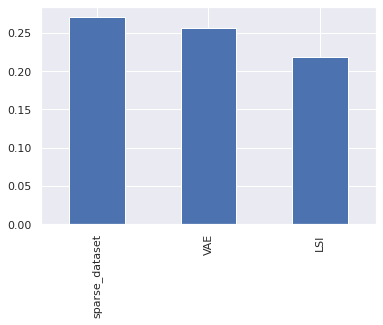

In [22]:
rmses.mean().loc[['sparse_dataset','VAE', 'LSI']].plot.bar()

In [23]:
rmses.mean(), rmses.std()

(sparse_dataset    0.270569
 LSI               0.218572
 VAE               0.256730
 dtype: float64,
 sparse_dataset    0.027743
 LSI               0.098890
 VAE               0.114657
 dtype: float64)

<AxesSubplot:xlabel='position', ylabel='position_bias'>

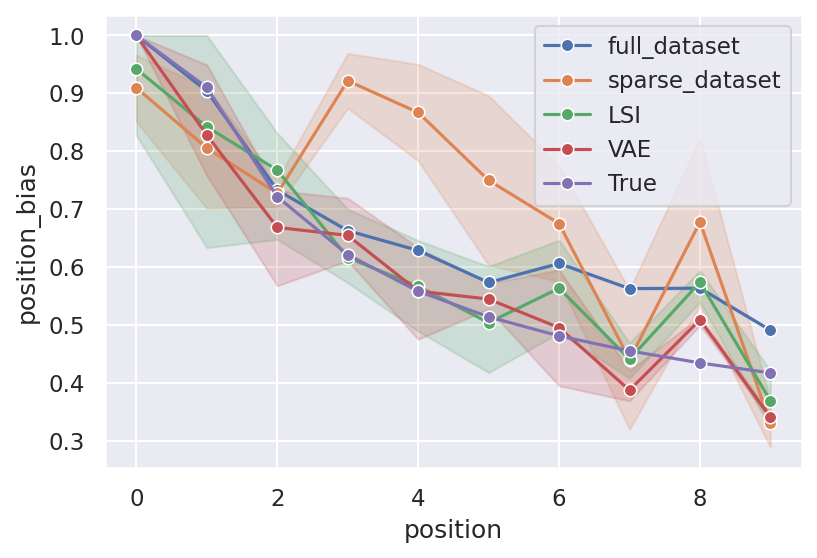

In [17]:
plt.figure(figsize=(6, 4), dpi=150)

sns.lineplot(data=pbias_real.reset_index(), x='position', y='position_bias',  marker='o', label='full_dataset')
sns.lineplot(data=pbias_subset.reset_index(), x='position', y='position_bias',  marker='o', label='sparse_dataset')
sns.lineplot(data=pbias_lsi.reset_index(), x='position', y='position_bias',  marker='o', label='LSI')
sns.lineplot(data=pbias_vae.reset_index(), x='position', y='position_bias', marker='o', label='VAE')
sns.lineplot(x=pd.Series(true_position_bias).index, y=pd.Series(true_position_bias),  marker='o', label='True')



<AxesSubplot:xlabel='position', ylabel='position_bias'>

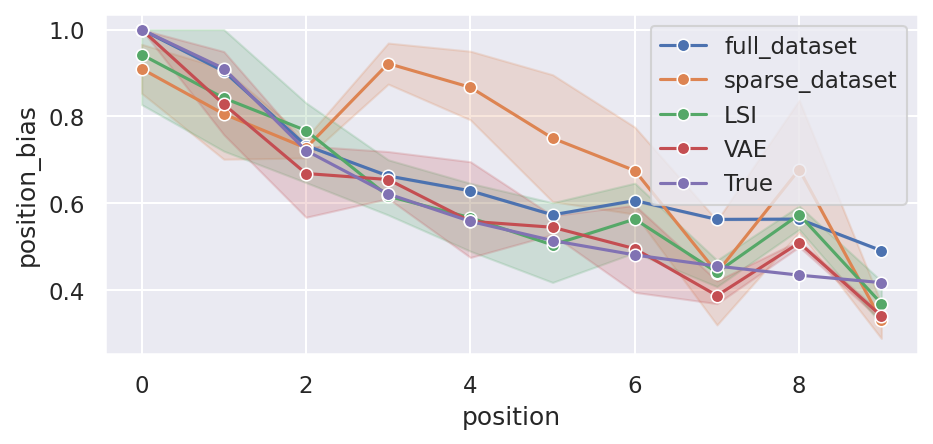

In [31]:
plt.figure(figsize=(7, 3), dpi=150)

sns.lineplot(data=pbias_real.reset_index(), x='position', y='position_bias',  marker='o', label='full_dataset')
sns.lineplot(data=pbias_subset.reset_index(), x='position', y='position_bias',  marker='o', label='sparse_dataset')
sns.lineplot(data=pbias_lsi.reset_index(), x='position', y='position_bias',  marker='o', label='LSI')
sns.lineplot(data=pbias_vae.reset_index(), x='position', y='position_bias', marker='o', label='VAE')
sns.lineplot(x=pd.Series(true_position_bias).index, y=pd.Series(true_position_bias),  marker='o', label='True')


## (4-2) calculate MRR

In [333]:
def mean_reciprocal_rank(actions, df):
    ranks = []
    click_idx = df['click'] == 1
    for idx in actions[click_idx].index:
        ranks.append(np.where(actions.values[idx] == df.loc[idx]['arm'])[0][0])
    return  (1/(np.array(ranks) + 1)).mean()

def mean_average_precision(actions, df, k=5):
    #assume click only hapens once for each user
    ranks = []
    click_idx = df['click'] == 1
    for idx in actions[click_idx].index:
        if df.loc[idx]['slot'] <= k:
            ranks.append(np.where(actions.values[idx] == df.loc[idx]['arm'])[0][0])
    return  (1/(np.array(ranks) + 1)).mean()/k


In [413]:
action_spec = {
    "arms": list(df.arm.unique()),
    "slots":list(df.slot.unique()),
}
policy_state_spec = {
    "model": "xgboost",
    "optimize_slot": False,
    "epsilon": 0,
    "epsilon_decay": 0.9,
    "epsilon_min": 0,
}

In [414]:
df = df.reset_index(drop=True)

In [415]:
pbiases = [pbias_real, pbias_subset, pbias_lsi, pbias_vae]
labels = ['real', 'subset', 'lsi', 'vae']
trials = 1
outs = []
for i in range(trials):
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=43)
    df_test = df_test.reset_index(drop=True)
    pscore = np.ones((len(df_train), len(df_train.slot.unique())))
    pscore /= len(df_train.slot.unique())
    bandit_feedback = {
        "action": df_train.arm.values,
        "position": df_train.slot.values,
        "reward": df_train.click.values,
        "n_rounds": len(df_train),
        "n_actions": len(df_train.arm.unique()),
        "pscore": pscore,
        "context": df_train.iloc[:, 5:].values
    }
    
    for pbias, label in zip(pbiases, labels):
        print(i, label)
        leg = LogisticEpsilonGreedy(action_spec, policy_state_spec=policy_state_spec)
        leg.pre_trained_position_bias = pbias.groupby('position')['position_bias'].mean().to_dict()
        leg.update(
            bandit_feedback["action"],
            bandit_feedback["reward"],
            context = bandit_feedback["context"],
            position = bandit_feedback["position"],
        )
        contexts = df_test.iloc[:, 5:]
        contexts['arm'] = df_test['arm']
        actions = leg.action(contexts.values)
        mrr = mean_reciprocal_rank(actions, df_test)
        map5 = mean_average_precision(actions, df_test, k=5)
        map10 = mean_average_precision(actions, df_test, k=10)
        out = [mrr, map5, map10, label]
        outs.append(out)
        print(out)

0 real
epsilon: {} 0.0
[0.08790955727246622, 0.016740192200620577, 0.008790955727246622, 'real']
0 subset
epsilon: {} 0.0
[0.0877320899958737, 0.017092269757843708, 0.00877320899958737, 'subset']
0 lsi
epsilon: {} 0.0
[0.09048978414384382, 0.01708432790042171, 0.009048978414384382, 'lsi']
0 vae
epsilon: {} 0.0
[0.08776580281799744, 0.017120562888933658, 0.008776580281799744, 'vae']


In [416]:
outs = pd.DataFrame(outs, columns=['MRR', 'MAP@5', 'MAP@10', 'method'])

In [417]:
outs.to_csv('result_metrics_obd.csv')

In [418]:
outs.groupby('method').mean()

,MRR,MAP@5,MAP@10
method,,,
lsi,0.090490,0.017084,0.009049
real,0.087910,0.016740,0.008791
subset,0.087732,0.017092,0.008773
vae,0.087766,0.017121,0.008777
